In [ ]:
# Cell 1: Setup & Configuration
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd
from scipy.stats import pearsonr
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import seaborn as sns
from scipy.stats import linregress

# Your existing configuration (unchanged)
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'l'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'r'}
}

COPE_MAP = {
    'face': 1,
    'word': 12,
    'object': 3,
    'house': 2
}

In [ ]:
# Cell 2: Extract Functional ROIs

def extract_functional_rois_final(subject_id, threshold_z=2.0):
    code = SUBJECTS[subject_id]['code']
    hemi = SUBJECTS[subject_id]['hemi']
    sessions = SUBJECTS[subject_id]['sessions']
    
    all_results = {}
    
    for category, cope_num in [('face', 1), ('word', 12), ('object', 3), ('house', 2)]:
        all_results[category] = {}
        
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

# Extract functional ROIs for both subjects
golarai_functional_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.0)

print("✓ Functional ROIs extracted!")

✓ Functional ROIs extracted!


In [ ]:
# Cell 3: RSA Helper Functions

def create_6mm_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create a 6mm sphere around a peak."""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def extract_beta_patterns_from_sphere(subject_id, session, sphere_mask, category_copes):
    """Extract beta values (cope estimates) from a 6mm sphere for all categories."""
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        if session == '01':
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1_ses01.nii.gz'
        
        if not cope_file.exists():
            continue
        
        cope_data = nib.load(cope_file).get_fdata()
        roi_betas = cope_data[sphere_mask]
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories

def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute Representational Dissimilarity Matrix."""
    correlation_matrix = np.corrcoef(beta_matrix.T)
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix

def extract_all_rdms_6mm_session_specific(functional_results):
    """Extract RDMs from 6mm spheres using SESSION-SPECIFIC ROIs."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{code}: SESSION-SPECIFIC RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, category_copes
                )
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

# Run with session-specific ROIs
print("STEP 1: SESSION-SPECIFIC ROI RSA")
print("="*70)
rsa_rdms_6mm_session_specific = extract_all_rdms_6mm_session_specific(golarai_functional_final)
print("✓ Session-specific analysis complete!")

STEP 1: SESSION-SPECIFIC ROI RSA

UD: SESSION-SPECIFIC RSA Analysis
  face ses-01: 898 voxels
  face ses-02: 903 voxels
  face ses-03: 906 voxels
  face ses-05: 899 voxels
  face ses-06: 900 voxels
  word ses-02: 908 voxels
  word ses-03: 901 voxels
  word ses-05: 902 voxels
  word ses-06: 896 voxels
  object ses-01: 902 voxels
  object ses-02: 904 voxels
  object ses-03: 906 voxels
  object ses-05: 900 voxels
  object ses-06: 907 voxels
  house ses-01: 904 voxels
  house ses-02: 909 voxels
  house ses-03: 904 voxels
  house ses-05: 915 voxels
  house ses-06: 908 voxels

TC: SESSION-SPECIFIC RSA Analysis
  face ses-01: 912 voxels
  face ses-02: 907 voxels
  face ses-03: 908 voxels
  word ses-01: 895 voxels
  word ses-02: 902 voxels
  word ses-03: 908 voxels
  object ses-01: 906 voxels
  object ses-02: 908 voxels
  object ses-03: 897 voxels
  house ses-01: 912 voxels
  house ses-02: 895 voxels
  house ses-03: 899 voxels
✓ Session-specific analysis complete!


In [ ]:
# Cell 4: Session-Specific RSA Analysis

def extract_all_rdms_6mm_session_specific(functional_results):
    """Extract RDMs from 6mm spheres using SESSION-SPECIFIC ROIs."""
    all_rdms = {}
    category_copes = {'face': 1, 'word': 12, 'object': 3, 'house': 2}
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = SUBJECTS[subject_id]['hemi']
        sessions = SUBJECTS[subject_id]['sessions']
        
        ref_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"\n{code}: SESSION-SPECIFIC RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                # SESSION-SPECIFIC peak and sphere
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_6mm_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_beta_patterns_from_sphere(
                    subject_id, session, sphere_mask, category_copes
                )
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

# Run with session-specific ROIs
print("STEP 1: SESSION-SPECIFIC ROI RSA")
print("="*70)
rsa_rdms_6mm_session_specific = extract_all_rdms_6mm_session_specific(golarai_functional_final)
print("✓ Session-specific analysis complete!")

STEP 1: SESSION-SPECIFIC ROI RSA

UD: SESSION-SPECIFIC RSA Analysis
  face ses-01: 898 voxels
  face ses-02: 903 voxels
  face ses-03: 906 voxels
  face ses-05: 899 voxels
  face ses-06: 900 voxels
  word ses-02: 908 voxels
  word ses-03: 901 voxels
  word ses-05: 902 voxels
  word ses-06: 896 voxels
  object ses-01: 902 voxels
  object ses-02: 904 voxels
  object ses-03: 906 voxels
  object ses-05: 900 voxels
  object ses-06: 907 voxels
  house ses-01: 904 voxels
  house ses-02: 909 voxels
  house ses-03: 904 voxels
  house ses-05: 915 voxels
  house ses-06: 908 voxels

TC: SESSION-SPECIFIC RSA Analysis
  face ses-01: 912 voxels
  face ses-02: 907 voxels
  face ses-03: 908 voxels
  word ses-01: 895 voxels
  word ses-02: 902 voxels
  word ses-03: 908 voxels
  object ses-01: 906 voxels
  object ses-02: 908 voxels
  object ses-03: 897 voxels
  house ses-01: 912 voxels
  house ses-02: 895 voxels
  house ses-03: 899 voxels
✓ Session-specific analysis complete!


In [6]:
# Cell 5 will be: Liu's RSA Methodology (preferred vs non-preferred correlations + bootstrapped slopes)

def compute_liu_distinctiveness(all_rdms):
    """Compute Liu's preferred vs non-preferred category correlations."""
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    distinctiveness_results = {}
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        distinctiveness_results[subject_id] = {}
        
        print(f"\n{code}: Liu's Distinctiveness Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['correlation_matrices']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            preferred_cat = roi_preferred[roi_name]
            if preferred_cat not in valid_cats:
                continue
            
            pref_idx = valid_cats.index(preferred_cat)
            nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
            
            distinctiveness_results[subject_id][roi_name] = {}
            
            for session, corr_matrix in roi_data['correlation_matrices'].items():
                pref_vs_nonpref = corr_matrix[pref_idx, nonpref_indices]
                mean_corr = np.mean(pref_vs_nonpref)
                
                distinctiveness_results[subject_id][roi_name][session] = {
                    'liu_distinctiveness': mean_corr,
                    'individual_correlations': pref_vs_nonpref
                }
                
                print(f"  {roi_name} ses-{session}: {mean_corr:.3f}")
    
    return distinctiveness_results

def compute_liu_bootstrapped_slopes(all_rdms, n_bootstraps=1000):
    """Liu's bootstrapped linear regression for dissimilarity changes."""
    slope_results = {}
    pairs = [('face', 'word'), ('house', 'object'), ('face', 'object'), ('word', 'house')]
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        slope_results[subject_id] = {}
        
        print(f"\n{code}: Liu's Bootstrapped Slope Analysis")
        
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            slope_results[subject_id][roi_name] = {}
            
            for cat1, cat2 in pairs:
                if cat1 not in valid_cats or cat2 not in valid_cats:
                    continue
                
                idx1, idx2 = valid_cats.index(cat1), valid_cats.index(cat2)
                
                session_nums, dissims = [], []
                for session in sessions:
                    if session in roi_data['rdms']:
                        rdm = roi_data['rdms'][session]
                        dissim = rdm[idx1, idx2]
                        session_nums.append(int(session))
                        dissims.append(dissim)
                
                if len(session_nums) < 2:
                    continue
                
                slope = linregress(session_nums, dissims)[0]
                
                null_slopes = []
                for _ in range(n_bootstraps):
                    shuffled = np.random.permutation(dissims)
                    null_slope = linregress(session_nums, shuffled)[0]
                    null_slopes.append(null_slope)
                
                ci_lower = np.percentile(null_slopes, 2.5)
                ci_upper = np.percentile(null_slopes, 97.5)
                significant = slope < ci_lower or slope > ci_upper
                
                slope_results[subject_id][roi_name][f'{cat1}-{cat2}'] = {
                    'observed_slope': slope,
                    'null_slopes': null_slopes,
                    'ci_95': (ci_lower, ci_upper),
                    'significant': significant
                }
                
                sig = "***" if significant else "n.s."
                print(f"  {roi_name} {cat1}-{cat2}: {slope:.4f} {sig}")
    
    return slope_results

# Run Liu's analyses
print("STEP 2: LIU'S RSA METHODOLOGY")
print("="*70)
liu_distinctiveness = compute_liu_distinctiveness(rsa_rdms_6mm_session_specific)
liu_slopes = compute_liu_bootstrapped_slopes(rsa_rdms_6mm_session_specific)
print("✓ Liu's methodology complete!")

STEP 2: LIU'S RSA METHODOLOGY

UD: Liu's Distinctiveness Analysis
  face ses-01: 0.007
  face ses-02: 0.411
  face ses-03: 0.019
  face ses-05: 0.099
  face ses-06: 0.119
  word ses-02: 0.045
  word ses-03: 0.640
  word ses-05: 0.258
  word ses-06: 0.117
  object ses-01: -0.360
  object ses-02: -0.878
  object ses-03: -0.302
  object ses-05: -0.479
  object ses-06: -0.432
  house ses-01: -0.757
  house ses-02: -0.886
  house ses-03: -0.354
  house ses-05: -1.030
  house ses-06: -0.432

TC: Liu's Distinctiveness Analysis
  face ses-01: -0.095
  face ses-02: 0.011
  face ses-03: 0.127
  word ses-01: 0.078
  word ses-02: 0.176
  word ses-03: 0.191
  object ses-01: -0.413
  object ses-02: -0.085
  object ses-03: 0.022
  house ses-01: -0.654
  house ses-02: -0.423
  house ses-03: -0.522

UD: Liu's Bootstrapped Slope Analysis
  face face-word: -0.1048 n.s.
  face house-object: 0.0964 n.s.
  face face-object: 0.1097 n.s.
  face word-house: 0.0734 n.s.
  word face-word: 0.0212 n.s.
  word hous

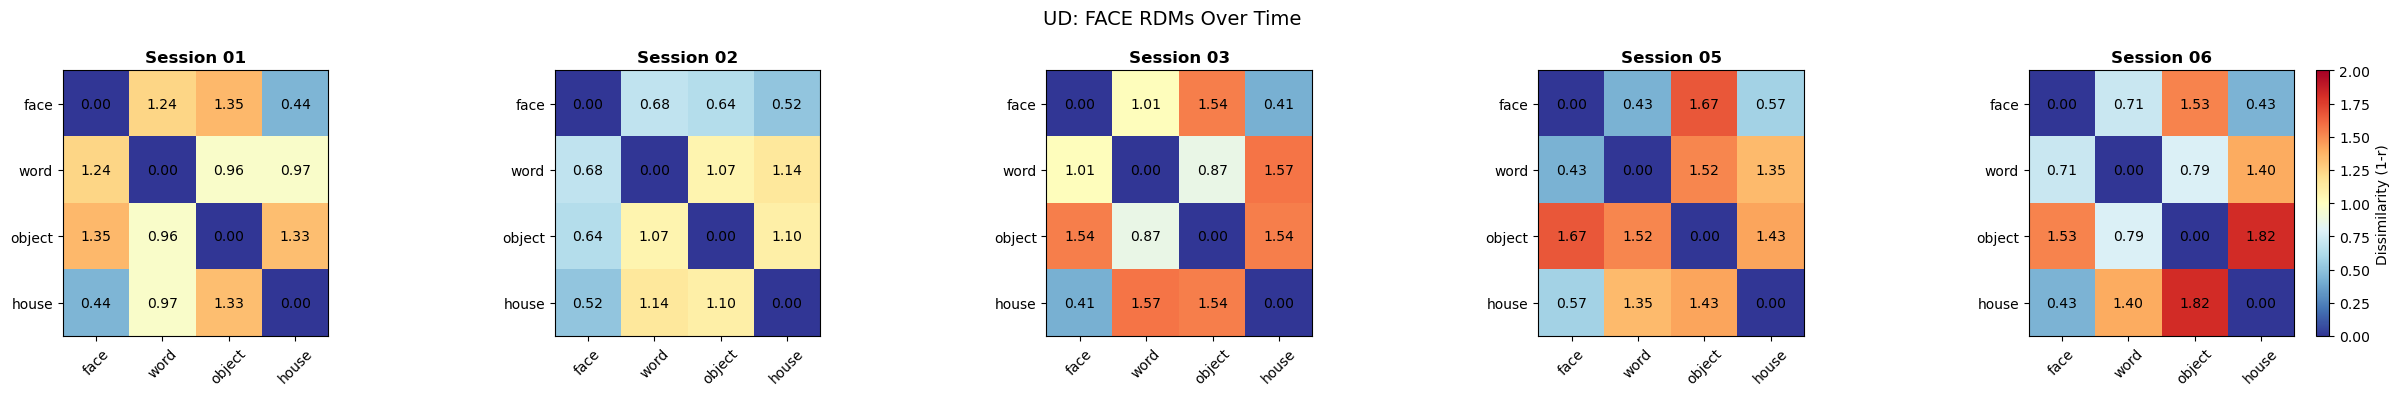

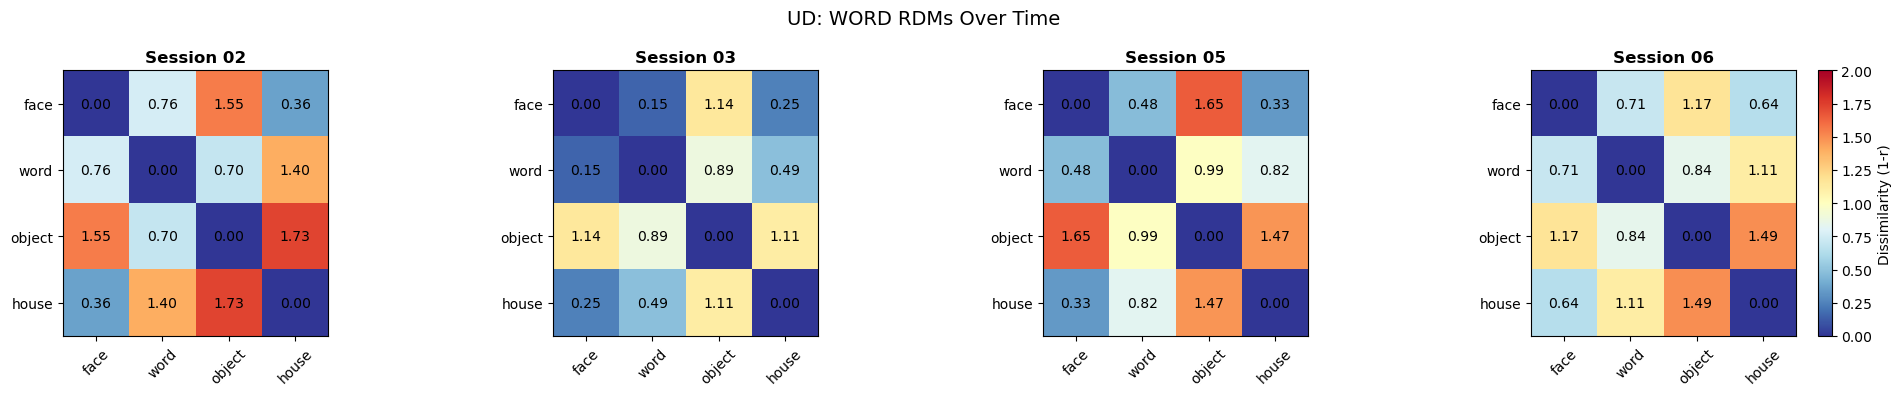

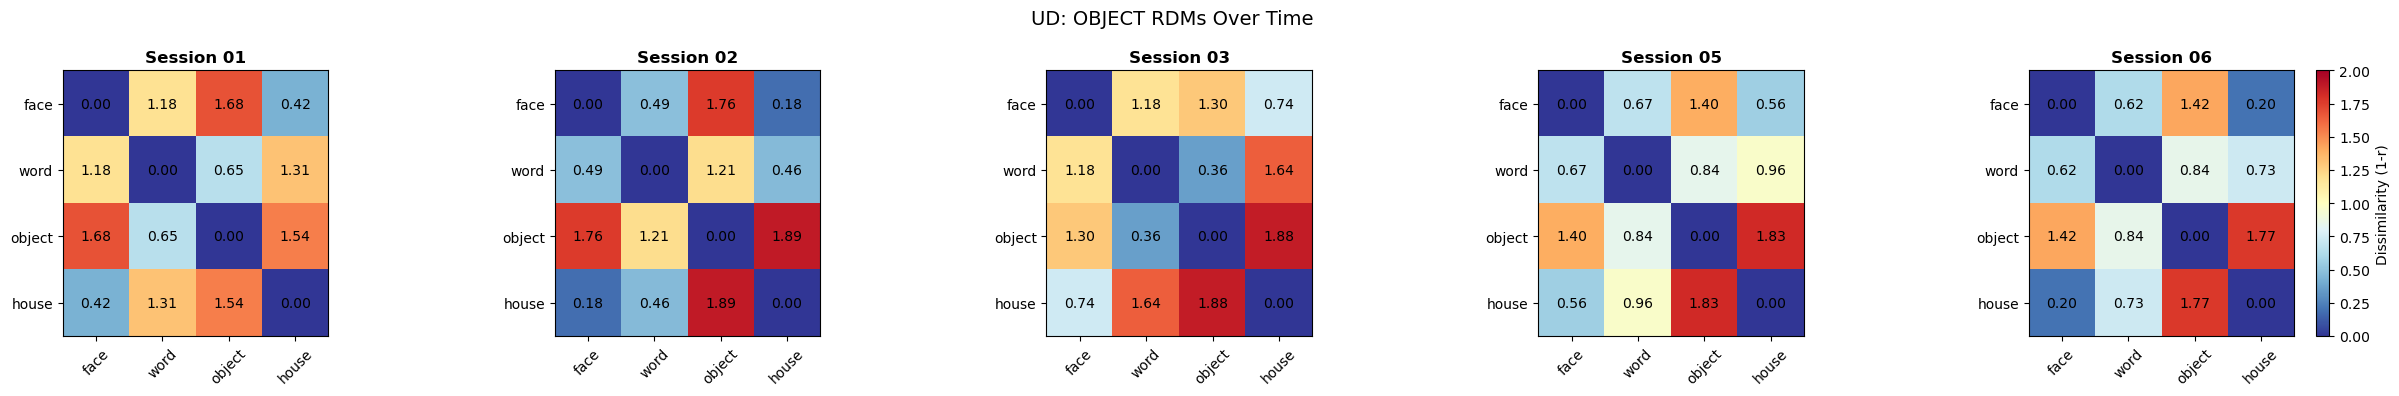

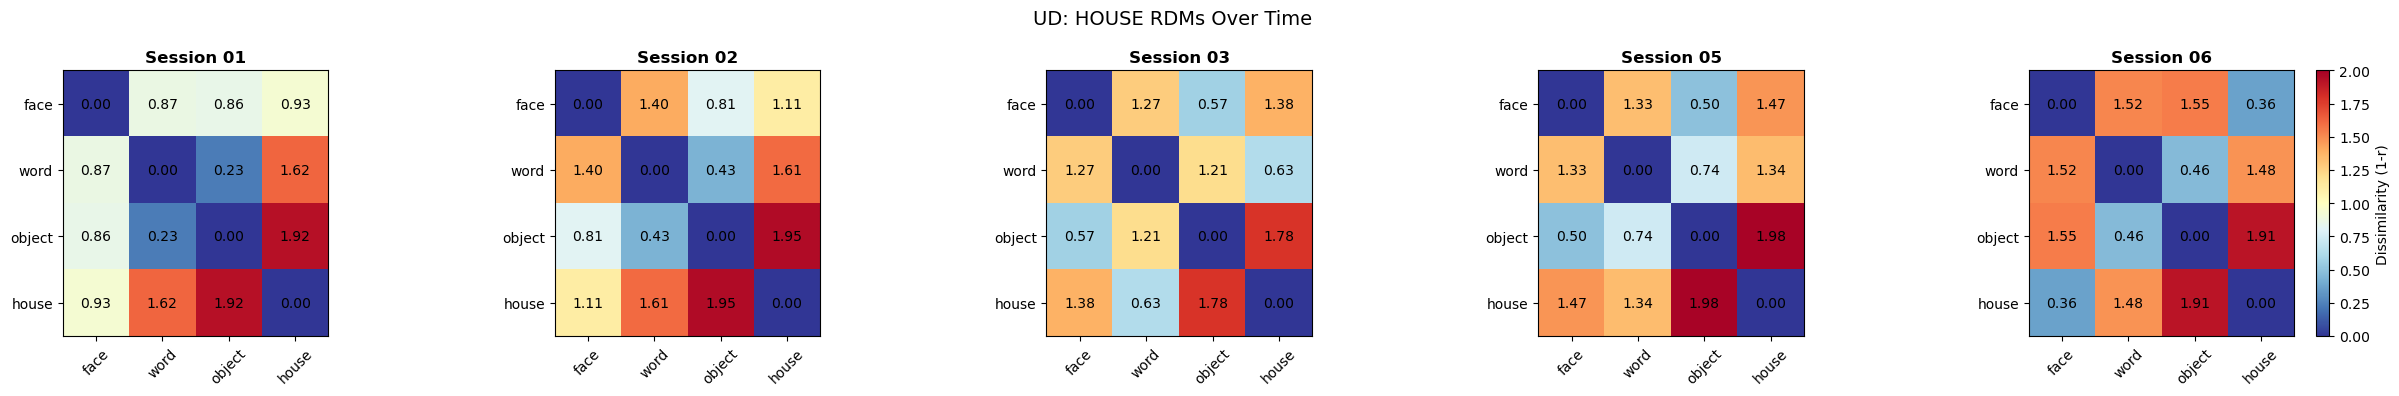

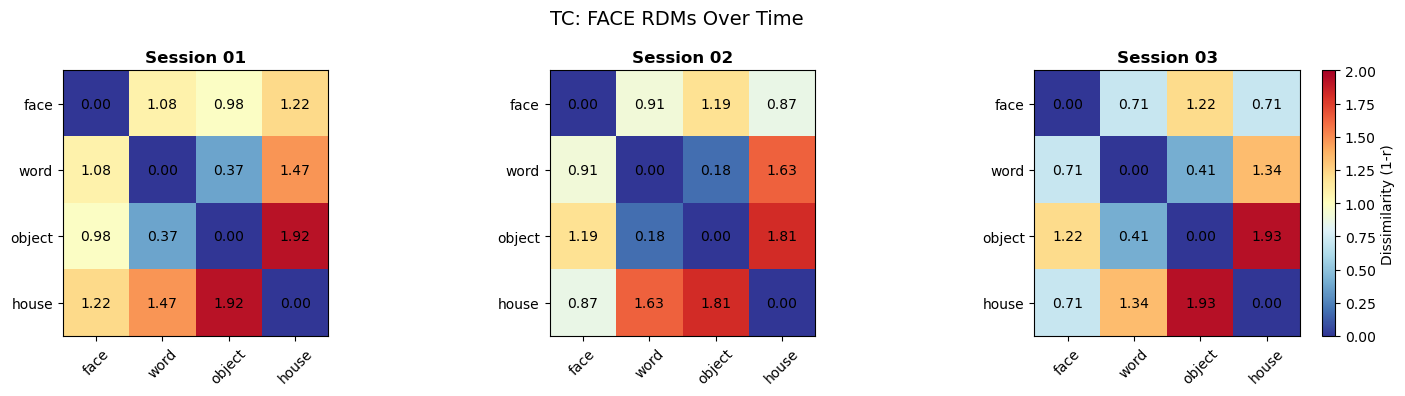

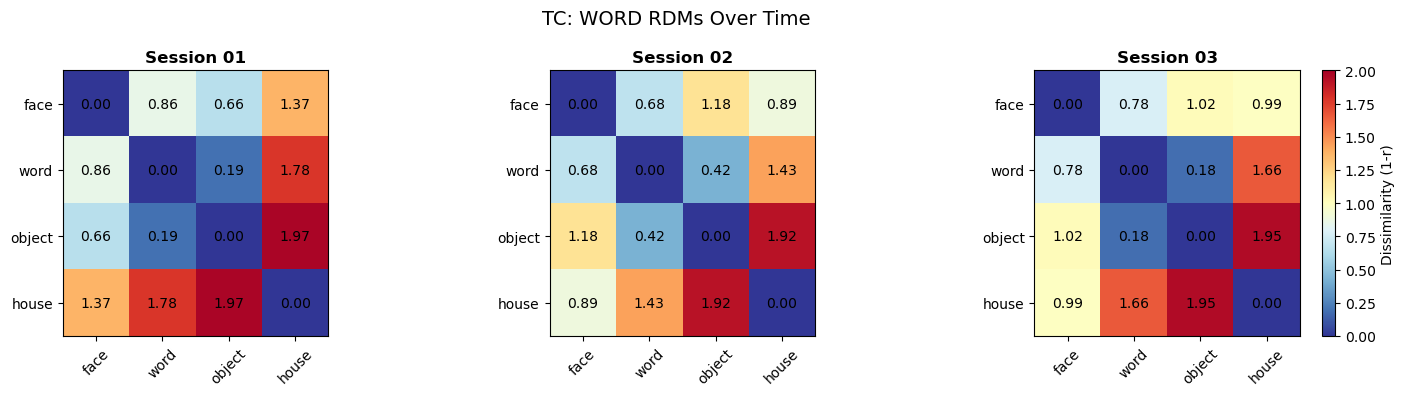

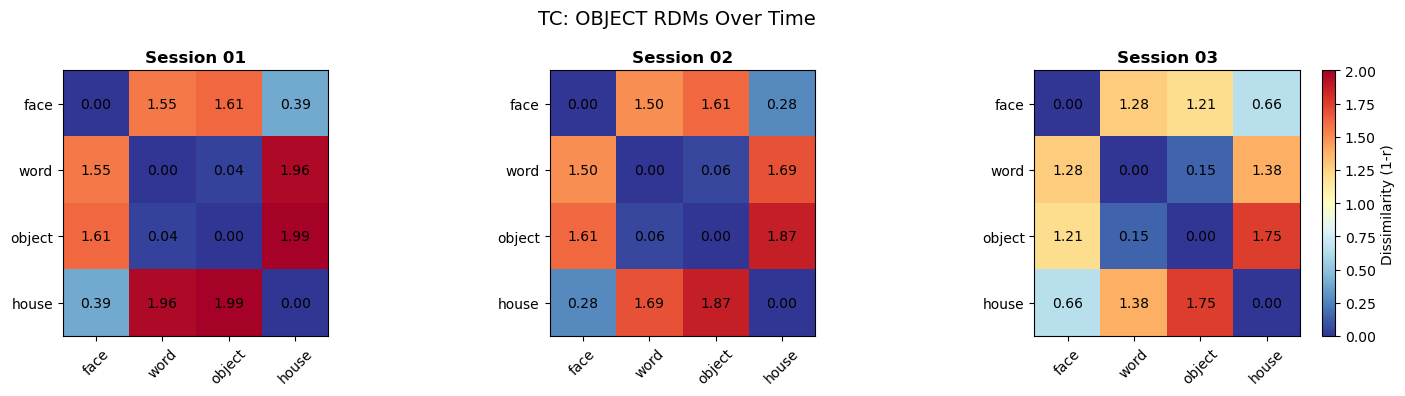

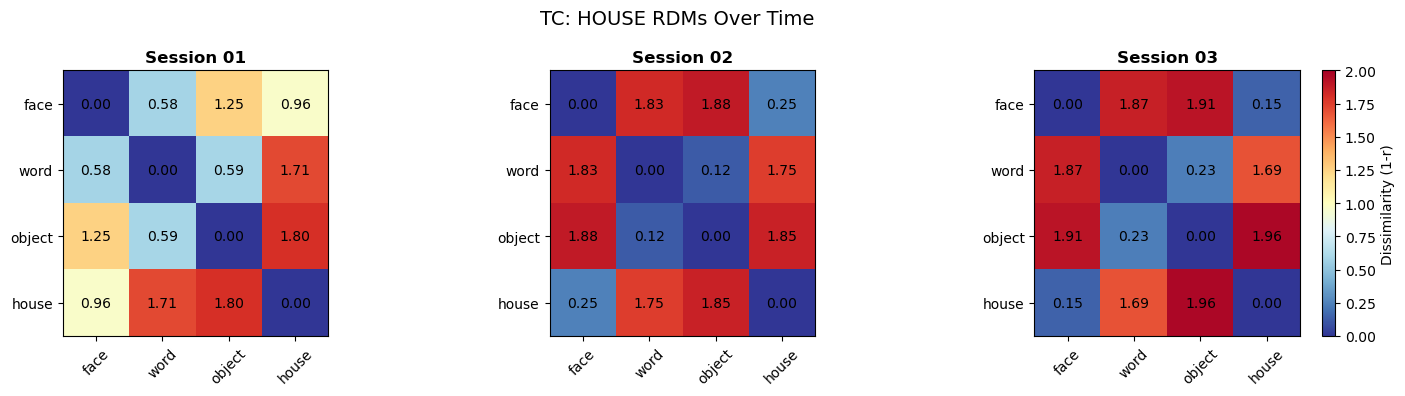

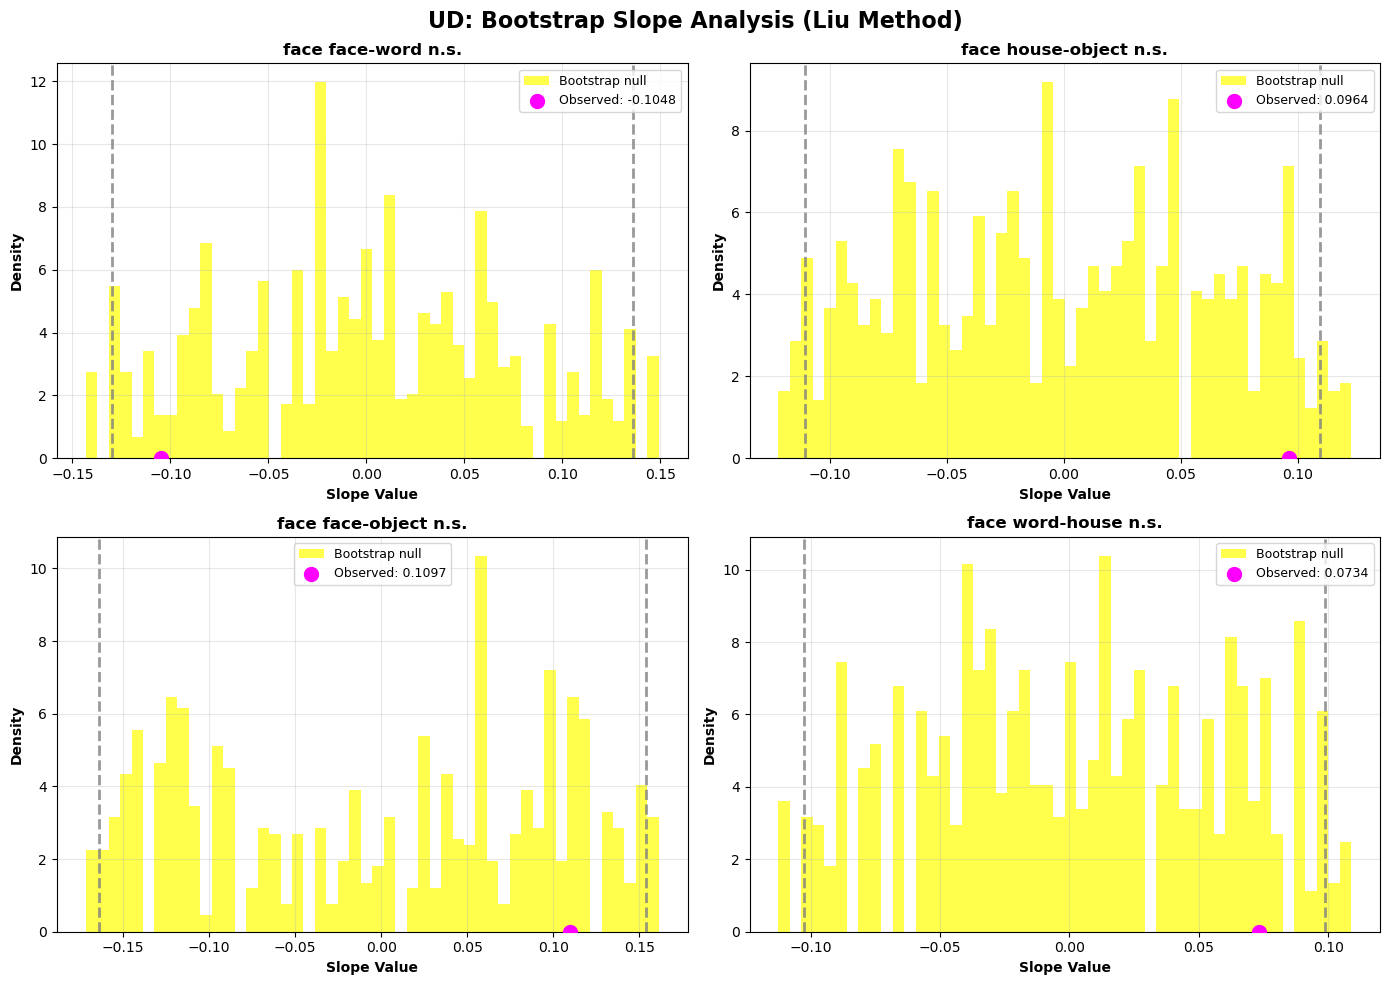

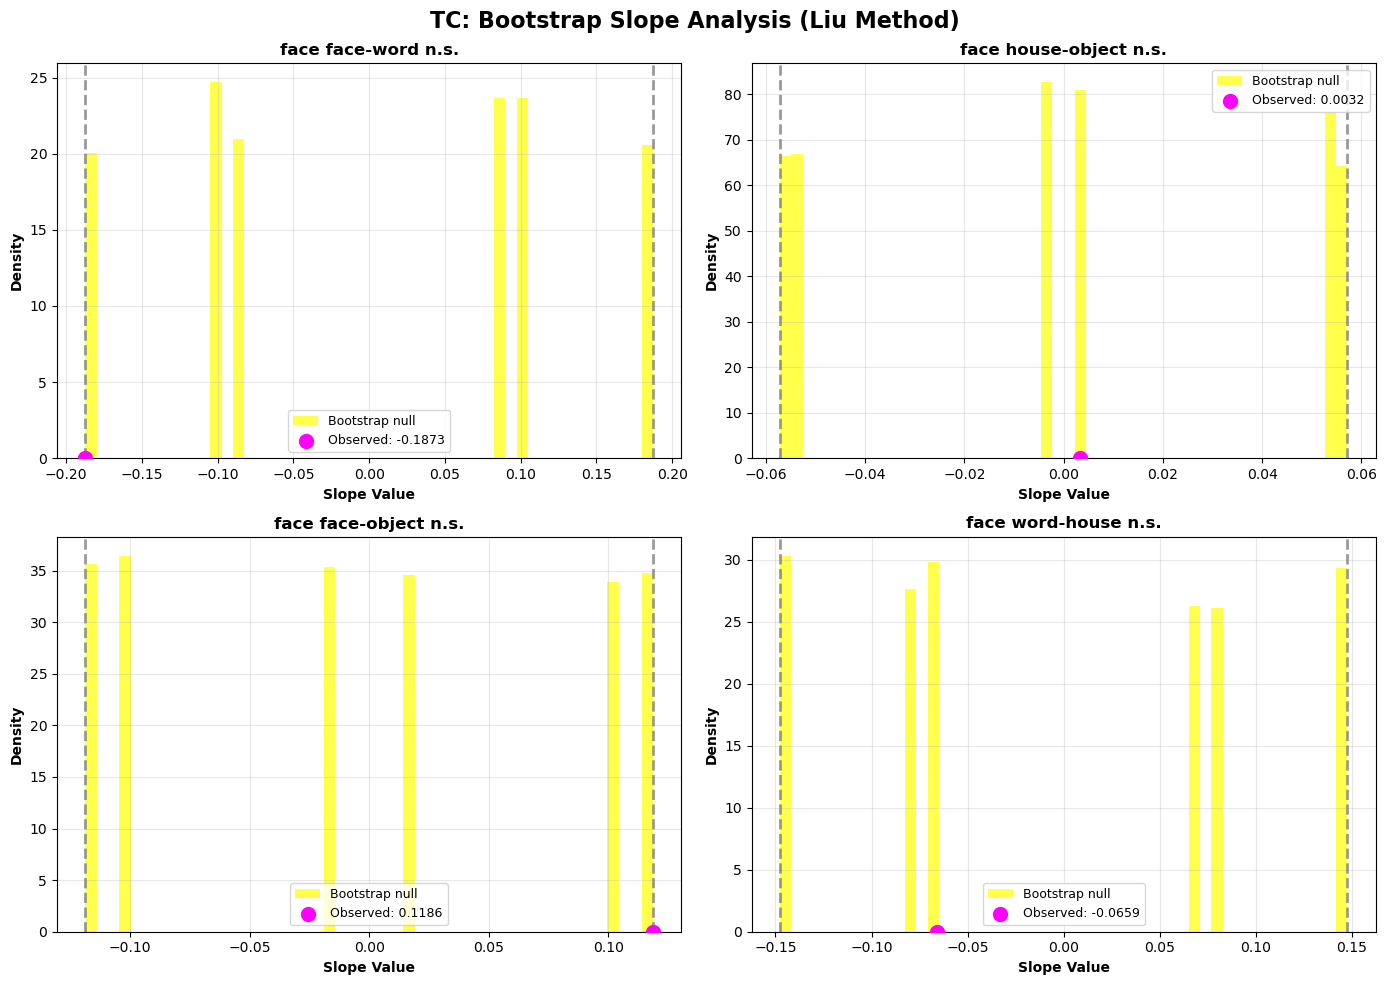

✓ Complete Liu-style visualization created!
SLOPE RESULTS FOR ALL FOUR ROIS:

UD:
----------------------------------------

  FACE ROI:
    face-word: -0.1048 n.s.
    house-object: 0.0964 n.s.
    face-object: 0.1097 n.s.
    word-house: 0.0734 n.s.

  WORD ROI:
    face-word: 0.0212 n.s.
    house-object: -0.0118 n.s.
    face-object: -0.0251 n.s.
    word-house: -0.0234 n.s.

  OBJECT ROI:
    face-word: -0.0756 n.s.
    house-object: 0.0244 n.s.
    face-object: -0.0647 n.s.
    word-house: -0.0592 n.s.

  HOUSE ROI:
    face-word: 0.0880 n.s.
    house-object: 0.0037 n.s.
    face-object: 0.0813 n.s.
    word-house: -0.0224 n.s.

TC:
----------------------------------------

  FACE ROI:
    face-word: -0.1873 n.s.
    house-object: 0.0032 n.s.
    face-object: 0.1186 n.s.
    word-house: -0.0659 n.s.

  WORD ROI:
    face-word: -0.0371 n.s.
    house-object: -0.0114 n.s.
    face-object: 0.1807 n.s.
    word-house: -0.0584 n.s.

  OBJECT ROI:
    face-word: -0.1392 n.s.
    house-

In [10]:
# CELL 5: PROPER LIU VISUALIZATION (COMPLETE VERSION)

def plot_complete_liu_results(all_rdms, slope_results):
    """Complete Liu-style visualization: RDMs + MDS + Bootstrap slopes."""
    
    for subject_id, categories in all_rdms.items():
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        # PART 1: RDM matrices across sessions (Liu's Figure 3 style)
        for roi_name, roi_data in categories.items():
            if not roi_data['rdms']:
                continue
                
            available_sessions = sorted(roi_data['rdms'].keys())
            n_sessions = len(available_sessions)
            
            fig, axes = plt.subplots(1, n_sessions, figsize=(5*n_sessions, 4))
            if n_sessions == 1:
                axes = [axes]
            
            valid_cats = roi_data['valid_categories']
            
            for idx, session in enumerate(available_sessions):
                rdm = roi_data['rdms'][session]
                
                im = axes[idx].imshow(rdm, cmap='RdYlBu_r', vmin=0, vmax=2)
                axes[idx].set_title(f'Session {session}', fontweight='bold')
                axes[idx].set_xticks(range(len(valid_cats)))
                axes[idx].set_yticks(range(len(valid_cats)))
                axes[idx].set_xticklabels(valid_cats, rotation=45)
                axes[idx].set_yticklabels(valid_cats)
                
                # Add correlation values in cells (Liu style)
                for i in range(len(valid_cats)):
                    for j in range(len(valid_cats)):
                        axes[idx].text(j, i, f'{rdm[i,j]:.2f}', 
                                     ha='center', va='center', fontsize=10)
            
            plt.colorbar(im, ax=axes[-1], label='Dissimilarity (1-r)')
            plt.suptitle(f'{code}: {roi_name.upper()} RDMs Over Time', fontsize=14)
            plt.tight_layout()
            plt.savefig(OUTPUT_DIR / f'{code}_{roi_name}_liu_rdms.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    # PART 2: Bootstrap slope analysis for ALL category pairs (Liu style)
    category_pairs = [('face', 'word'), ('house', 'object'), ('face', 'object'), ('word', 'house')]
    
    for subject_id, rois in slope_results.items():
        code = SUBJECTS[subject_id]['code']
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        pair_idx = 0
        for roi_name, pairs in rois.items():
            for pair_name, data in pairs.items():
                if pair_idx >= 4:
                    break
                
                ax = axes[pair_idx]
                
                # Liu's bootstrap histogram (yellow)
                ax.hist(data['null_slopes'], bins=50, alpha=0.7, color='yellow', 
                       density=True, label='Bootstrap null')
                
                # Observed slope (magenta circle - Liu's style)
                ax.scatter(data['observed_slope'], 0, s=100, color='magenta', 
                          marker='o', zorder=5, label=f'Observed: {data["observed_slope"]:.4f}')
                
                # 95% CI (gray dashed lines - Liu's style)
                ci_lower, ci_upper = data['ci_95']
                ax.axvline(ci_lower, color='gray', linestyle='--', linewidth=2, alpha=0.8)
                ax.axvline(ci_upper, color='gray', linestyle='--', linewidth=2, alpha=0.8)
                
                # Significance marking
                sig_marker = "***" if data['significant'] else "n.s."
                ax.set_title(f'{roi_name} {pair_name} {sig_marker}', fontweight='bold')
                ax.set_xlabel('Slope Value', fontweight='bold')
                ax.set_ylabel('Density', fontweight='bold')
                ax.legend(fontsize=9)
                ax.grid(True, alpha=0.3)
                
                pair_idx += 1
        
        plt.suptitle(f'{code}: Bootstrap Slope Analysis (Liu Method)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'{code}_liu_bootstrap_complete.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create complete Liu visualization
plot_complete_liu_results(rsa_rdms_6mm_session_specific, liu_slopes)
print("✓ Complete Liu-style visualization created!")

# Print slope results organized by ROI
print("SLOPE RESULTS FOR ALL FOUR ROIS:")
print("="*70)

for subject_id, rois in liu_slopes.items():
    code = SUBJECTS[subject_id]['code']
    print(f"\n{code}:")
    print("-" * 40)
    
    for roi_name in ['face', 'word', 'object', 'house']:
        if roi_name in rois:
            print(f"\n  {roi_name.upper()} ROI:")
            for pair_name, data in rois[roi_name].items():
                slope = data['observed_slope']
                sig = "***" if data['significant'] else "n.s."
                print(f"    {pair_name}: {slope:.4f} {sig}")
        else:
            print(f"\n  {roi_name.upper()} ROI: No data")